<a href="https://colab.research.google.com/github/gokulbytes/FutureWithARIMA/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [1]:
import pandas as pd
import numpy as np

df=pd.read_csv('/content/TimeSeries_TotalSolarGen_and_Load_IT_2016.csv')
df.head(10)

,utc_timestamp,IT_load_new,IT_solar_generation
0,2016-01-01T00:00:00Z,21665.0,1
1,2016-01-01T01:00:00Z,20260.0,0
2,2016-01-01T02:00:00Z,19056.0,0
3,2016-01-01T03:00:00Z,18407.0,0
4,2016-01-01T04:00:00Z,18425.0,0
5,2016-01-01T05:00:00Z,19261.0,0
6,2016-01-01T06:00:00Z,19673.0,49
7,2016-01-01T07:00:00Z,19927.0,576
8,2016-01-01T08:00:00Z,21403.0,1926
9,2016-01-01T09:00:00Z,22819.0,3271


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   utc_timestamp        8784 non-null   object 
 1   IT_load_new          8712 non-null   float64
 2   IT_solar_generation  8784 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 206.0+ KB


## Load Generation

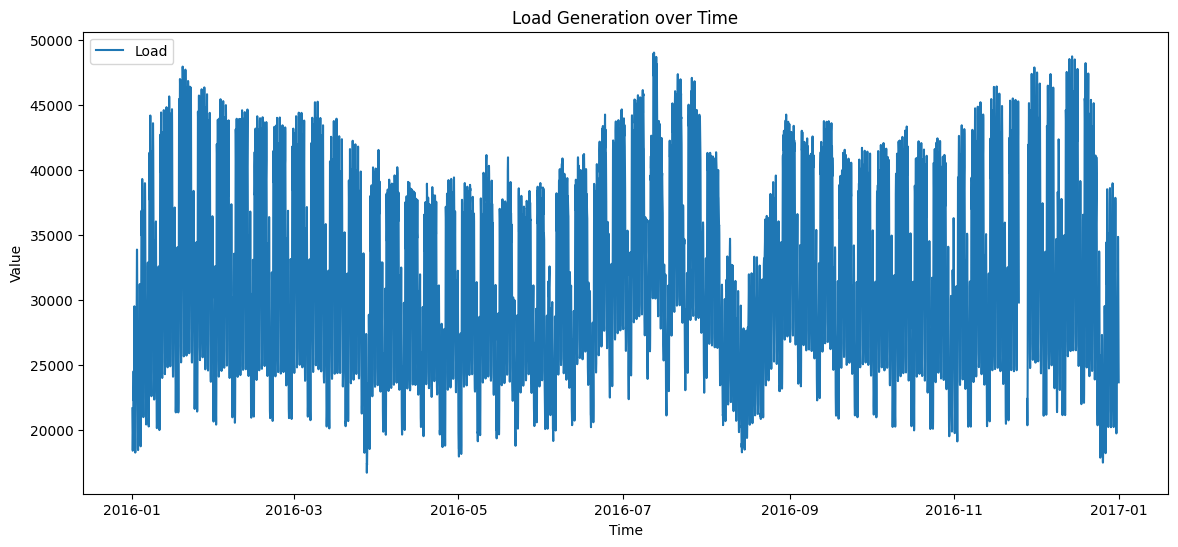

In [3]:
import matplotlib.pyplot as plt

df['utc_timestamp']=pd.to_datetime(df['utc_timestamp'])

plt.figure(figsize=(14,6))
plt.plot(df['utc_timestamp'],df['IT_load_new'],label='Load')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Load Generation over Time')
plt.show()

## Solar Generation

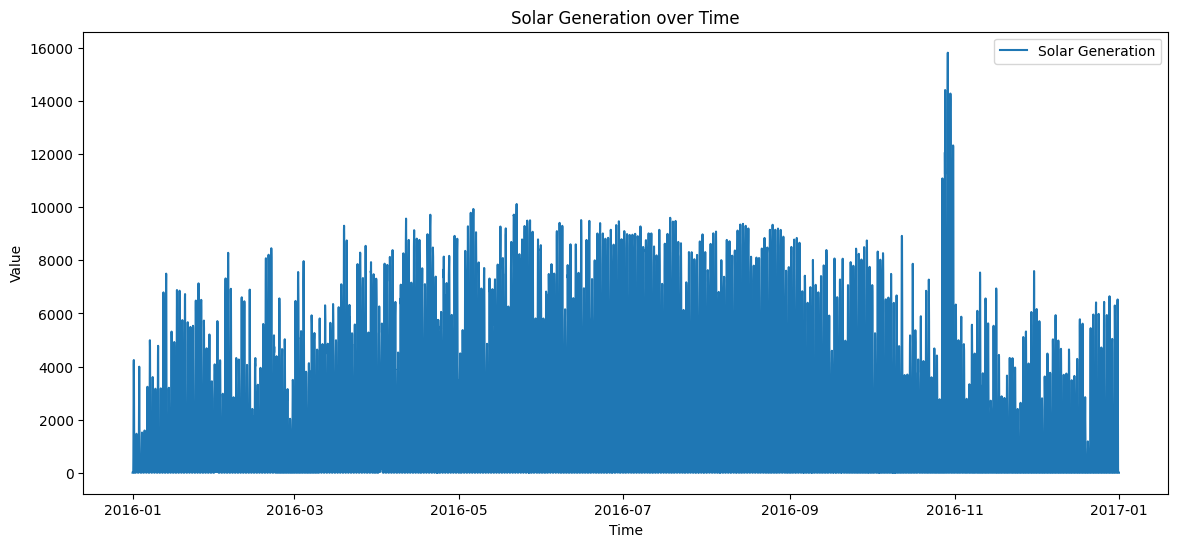

In [4]:
plt.figure(figsize=(14,6))
plt.plot(df['utc_timestamp'],df['IT_solar_generation'],label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Solar Generation over Time')
plt.show()

## Load and Solar Generation

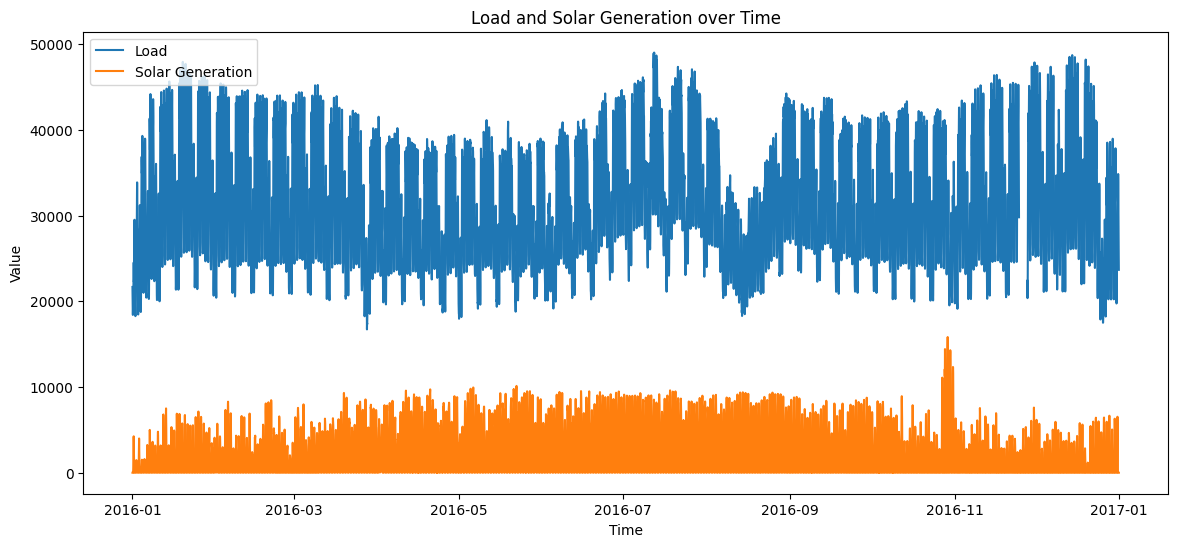

In [5]:
plt.figure(figsize=(14,6))
plt.plot(df['utc_timestamp'],df['IT_load_new'],label='Load')
plt.plot(df['utc_timestamp'],df['IT_solar_generation'],label='Solar Generation')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Load and Solar Generation over Time')
plt.show()

# Handle Missing Values

In [6]:
df['IT_load_new'].fillna(method='ffill',inplace=True)

/tmp/ipython-input-3359036581.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['IT_load_new'].fillna(method='ffill',inplace=True)
/tmp/ipython-input-3359036581.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['IT_load_new'].fillna(method='ffill',inplace=True)


In [7]:
df.isnull().sum()

,0
utc_timestamp,0
IT_load_new,0
IT_solar_generation,0


# ADF Test

## Check for Stationarity

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    dftest=adfuller(timeseries,autolag='AIC')
    dfoutput=pd.Series(dftest[0:4],index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key]=value
    print(dfoutput)

## Load Generation

In [9]:
adf_test(df['IT_load_new'])

Test Statistic                -1.197390e+01
p-value                        3.841445e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.746000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


## Solar Generation

In [10]:
adf_test(df['IT_solar_generation'])

Test Statistic                -5.741335e+00
p-value                        6.265438e-07
#Lags Used                     3.600000e+01
Number of Observations Used    8.747000e+03
Critical Value (1%)           -3.431098e+00
Critical Value (5%)           -2.861870e+00
Critical Value (10%)          -2.566946e+00
dtype: float64


# ACF & PACF Plots

## Load Generation

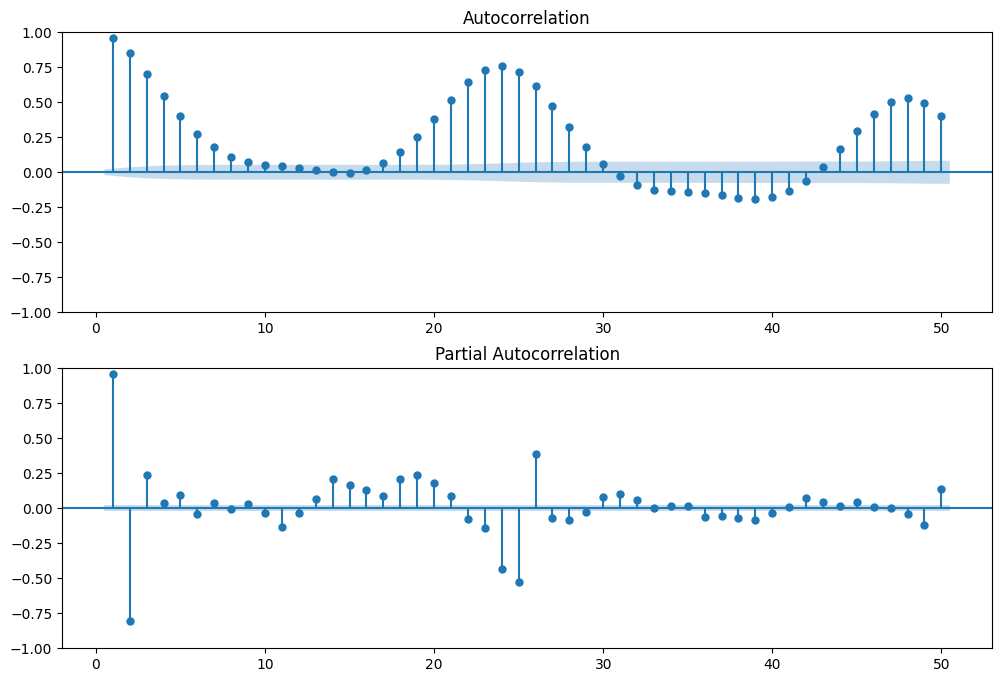

In [11]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig,(ax1, ax2)=plt.subplots(2,1,figsize=(12,8))
plot_acf(df['IT_load_new'],lags=50,zero=False,ax=ax1)
plot_pacf(df['IT_load_new'],lags=50,zero=False,ax=ax2)
plt.show()

## Solar Generation

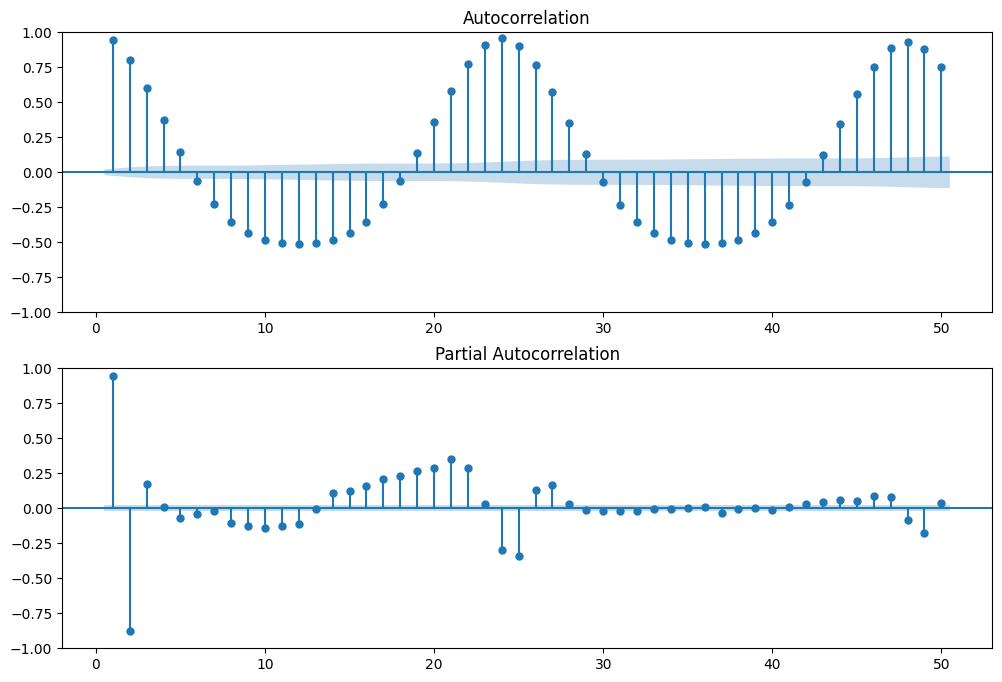

In [12]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(12,8))
plot_acf(df['IT_solar_generation'],lags=50,zero=False,ax=ax1)
plot_pacf(df['IT_solar_generation'],lags=50,zero=False,ax=ax2)
plt.show()

# ARIMA Model

## Load Generation

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and test sets
train_size=int(len(df['IT_load_new'])*0.8)
train,test=df['IT_load_new'][:train_size],df['IT_load_new'][train_size:]

# Fit the ARIMA model
model=ARIMA(train,order=(2,0,2))
model_fit=model.fit()

# Make predictions on the test set
predictions=model_fit.predict(start=len(train),end=len(train)+len(test)-1)

# Calculate RMSE
rmse=sqrt(mean_squared_error(test,predictions))
rmse

7714.95213482925

In [14]:
# Fit the ARIMA model
model2=ARIMA(train,order=(2,1,2))
model_fit2=model2.fit()

# Make predictions on the test set
predictions2=model_fit2.predict(start=len(train),end=len(train)+len(test)-1)

# Calculate RMSE
rmse2=sqrt(mean_squared_error(test,predictions2))
rmse2

7993.84942771682

In [15]:
# Fit the ARIMA model
model3=ARIMA(train,order=(2,2,2))
model_fit3=model3.fit()

# Make predictions on the test set
predictions3=model_fit3.predict(start=len(train),end=len(train)+len(test)-1)

# Calculate RMSE
rmse3=sqrt(mean_squared_error(test,predictions3))
rmse3

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9290.388604796251

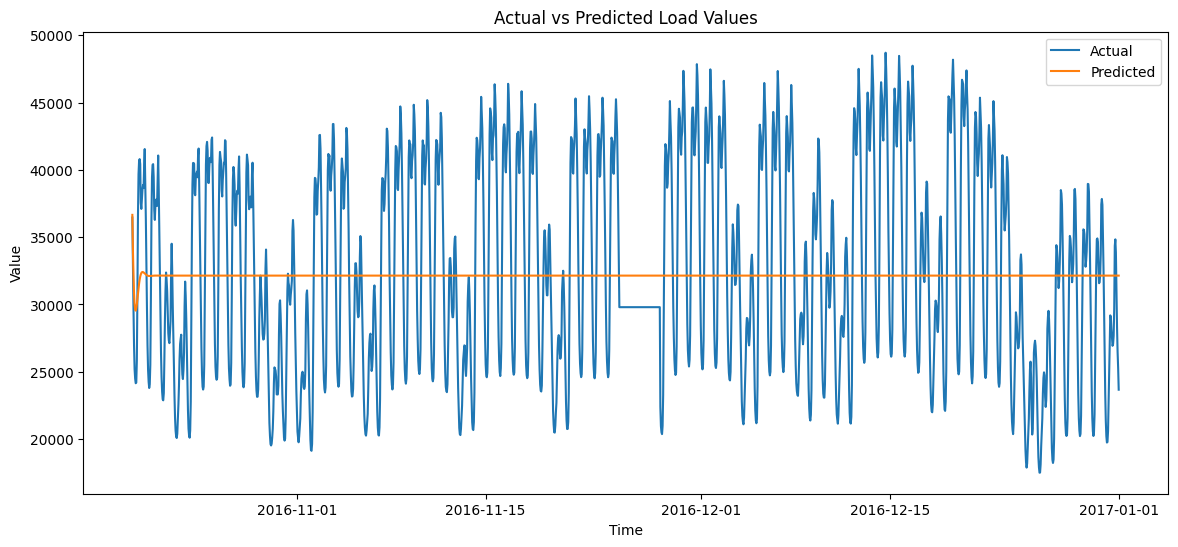

In [16]:
# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(df['utc_timestamp'][train_size:],test,label='Actual')
plt.plot(df['utc_timestamp'][train_size:],predictions,label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

## Solar Generation

In [17]:
# Split the data into training and test sets
train_size=int(len(df['IT_solar_generation'])*0.8)
train,test=df['IT_solar_generation'][:train_size],df['IT_solar_generation'][train_size:]

# Fit the ARIMA model
model=ARIMA(train,order=(2,0,2))
model_fit=model.fit()

# Make predictions on the test set
predictions=model_fit.predict(start=len(train),end=len(train)+len(test)-1)

# Calculate RMSE
rmse=sqrt(mean_squared_error(test,predictions))
rmse

2486.1507110911857

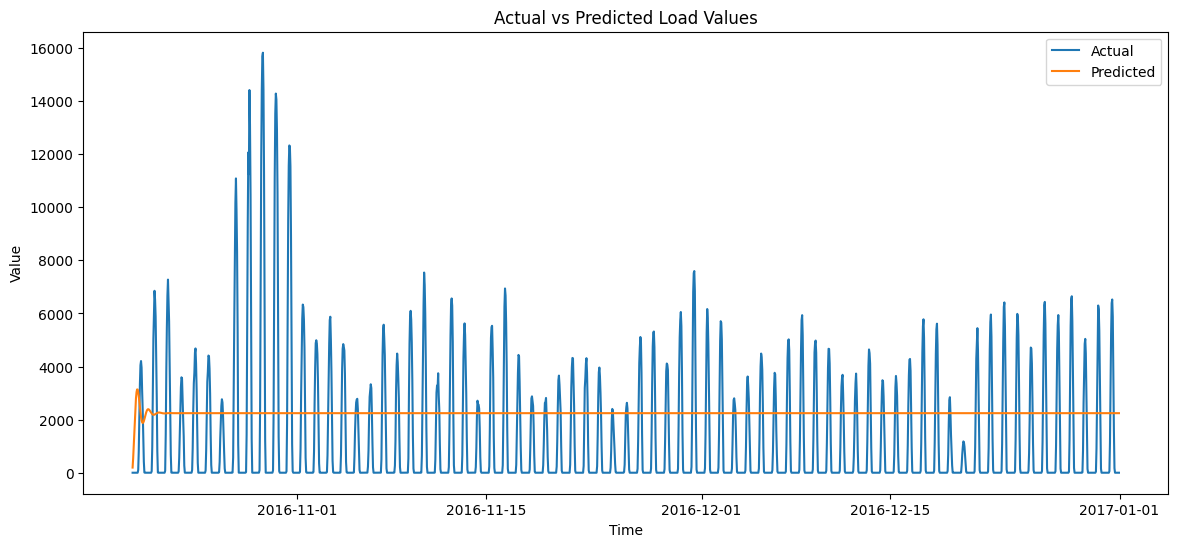

In [18]:
# Plot actual vs predicted values
plt.figure(figsize=(14,6))
plt.plot(df['utc_timestamp'][train_size:],test,label='Actual')
plt.plot(df['utc_timestamp'][train_size:],predictions,label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.title('Actual vs Predicted Load Values')
plt.show()

In [19]:
import joblib

joblib.dump(model,'forecast_model.pkl')

['forecast_model.pkl']